In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3)
sns.set_palette('Set3', n_colors=25)
%matplotlib inline
from collections import defaultdict
from scipy.stats import entropy
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
out_path = './'

data = pd.read_csv('./enrichment.csv', index_col=0) # read in our data
print data.columns.values

['DENV1_30dpi' 'EVU' 'DENV3_30dpi' 'DENV4_30dpi' 'H' 'input' 'A' 'C' 'B'
 'E' 'D' 'G' 'F' 'I' 'DENV2_30dpi' 'K' 'M' 'L' 'O' 'N' 'Q' 'P' 'R' 'U' 'T'
 'beads' 'virus' 'start' 'end' 'sequence' 'start.1' 'end.1' 'strains']


In [3]:
data.drop(['start.1', 'end.1', 'beads', 'input'], axis=1, inplace=True) # drop duplicate or uninformative columns

metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains'] # nonnumeric columns
sample_cols = [c for c in data.columns.values if c not in metadata_cols] # data columns

print data.head() # peek at the first few rows

                DENV1_30dpi       EVU  DENV3_30dpi  DENV4_30dpi         H  \
id                                                                          
1                  5.342450  0.344297     0.348807     0.338078  0.223641   
100                0.153189  0.024564     0.313813     0.530782  0.257395   
1001               0.202503  0.142185     0.503929     0.791249  0.000000   
1002               1.717832  6.749681     0.677535     0.960523  4.661363   
1008.1177.1346     0.401863  0.290015     0.481123     0.302460  0.888652   

                       A         C         B         E         D  \
id                                                                 
1               0.844821  0.297357  1.005429  0.949002  0.437357   
100             0.451624  0.847315  0.888415  0.373681  0.118446   
1001            0.870367  0.900856  0.827343  0.937925  0.166426   
1002            2.970106  1.747152  2.268064  3.668605  1.990157   
1008.1177.1346  0.813334  0.632322  0.608222  0.5038

In [4]:
def find_all_oligos(virus, site, data=data):
    '''
    find all the integer indices 
    in the dataframe that correspond to oligos 
    containing that site
    '''
    indices = np.where((data['virus']==virus) &
                 (data['start'] <= site) & 
                 (site <= data['end']))
    return indices[0]
    
def aggregate_site(virus, site, data):
    '''Return a series of the mean value of each column for all oligos containing the input site'''
    indices = find_all_oligos(virus, site, data)
    entries = data.iloc[indices]
    agg = entries.mean(axis=0)
    return agg
        
def aggregate_virus_sites(virus, data=data):
    ''' For all sites in the viral genome in the dataset, fetch the aggregated values of all oligos containing that site'''
    first_site = data.loc[data['virus'] == virus]['start'].min()
    last_site = data.loc[data['virus']==virus]['end'].max()
    
    sites = range(first_site, last_site)
    aggregated_sites = { site: aggregate_site(virus, site, data) for site in sites }

    df = pd.DataFrame.from_dict(aggregated_sites, orient='index')
    df.to_csv(out_path + virus + '_sitewise_enrichment.csv')
    return df

site_maps = {virus: aggregate_virus_sites(virus) for virus in pd.unique(data['virus'])}

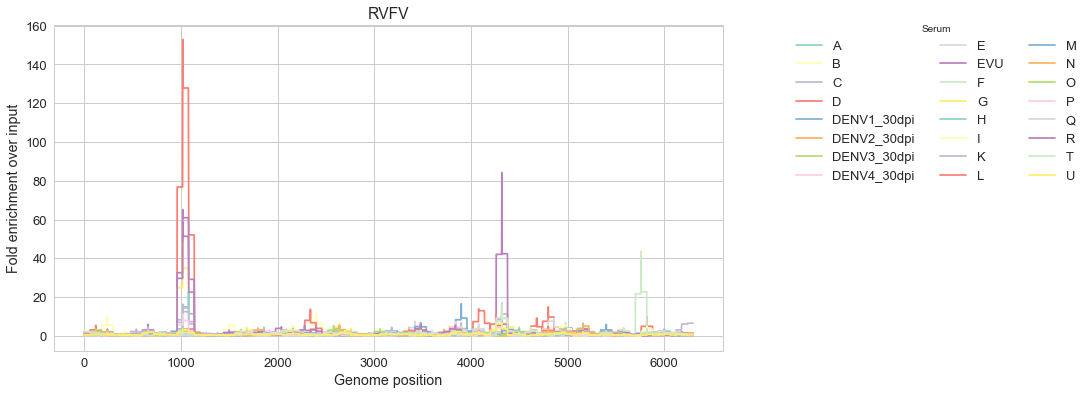

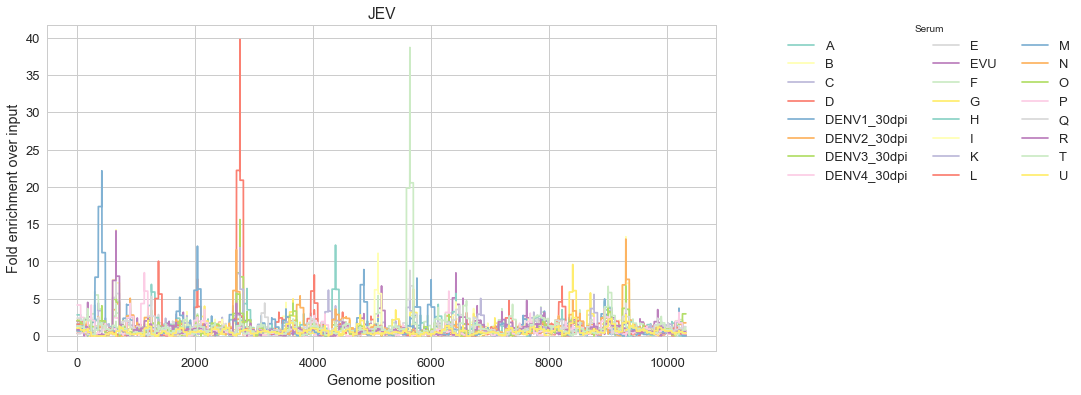

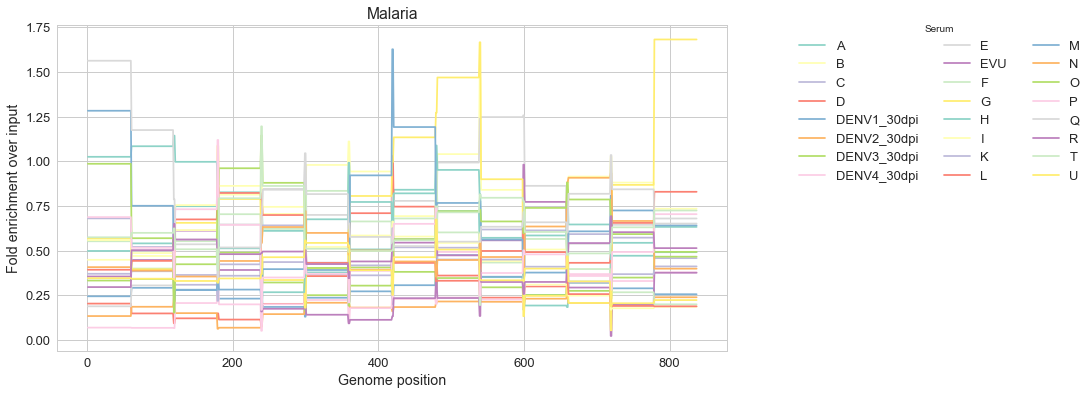

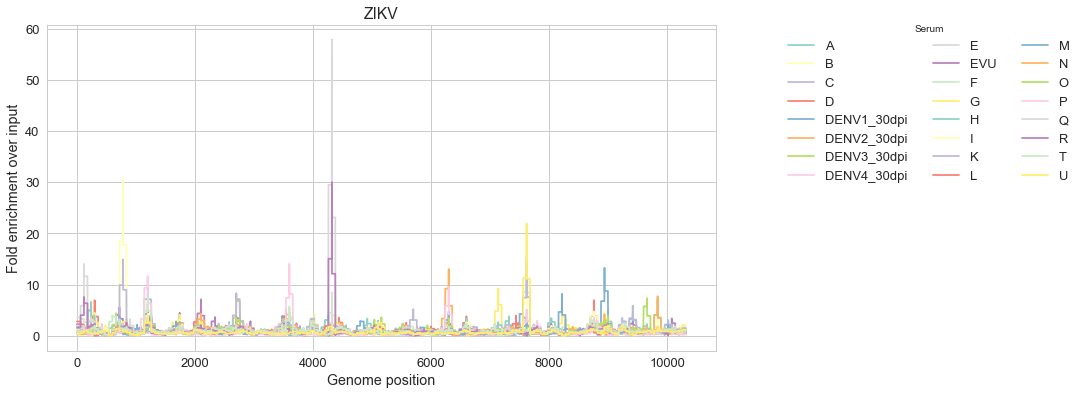

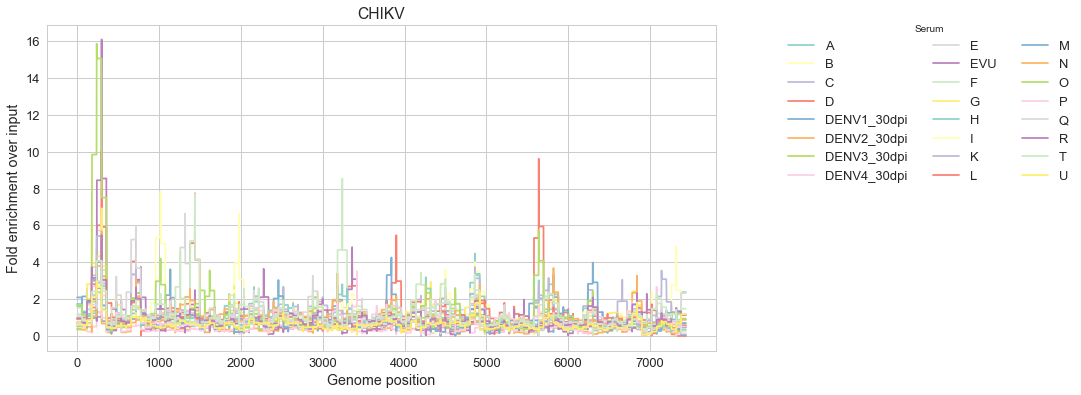

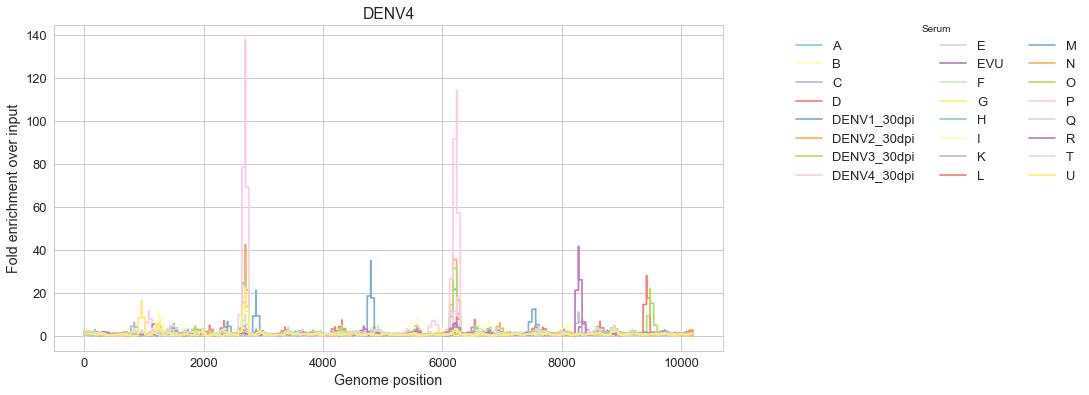

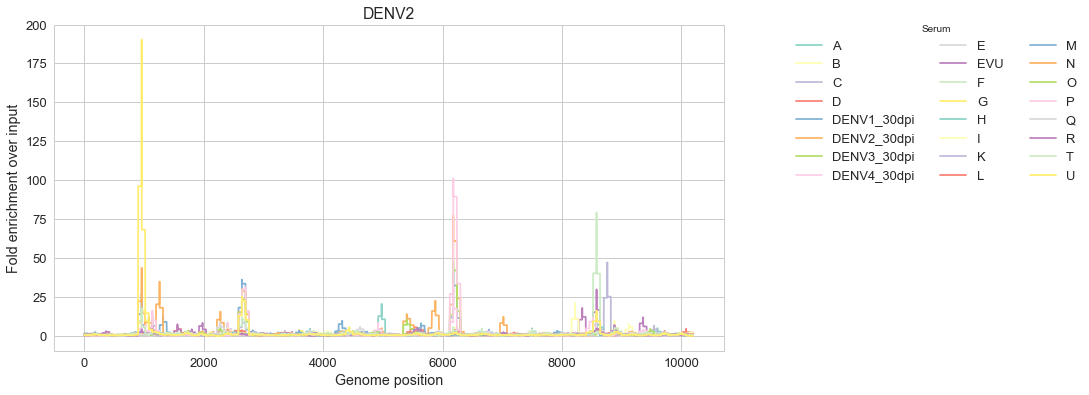

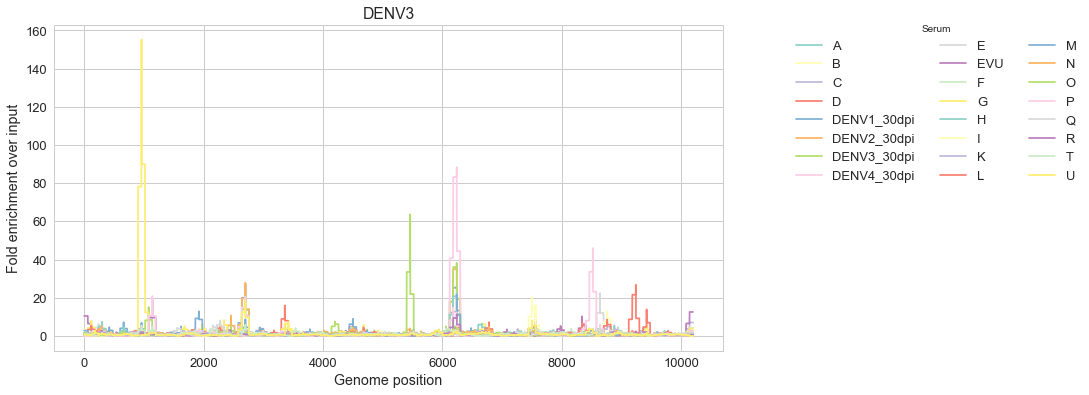

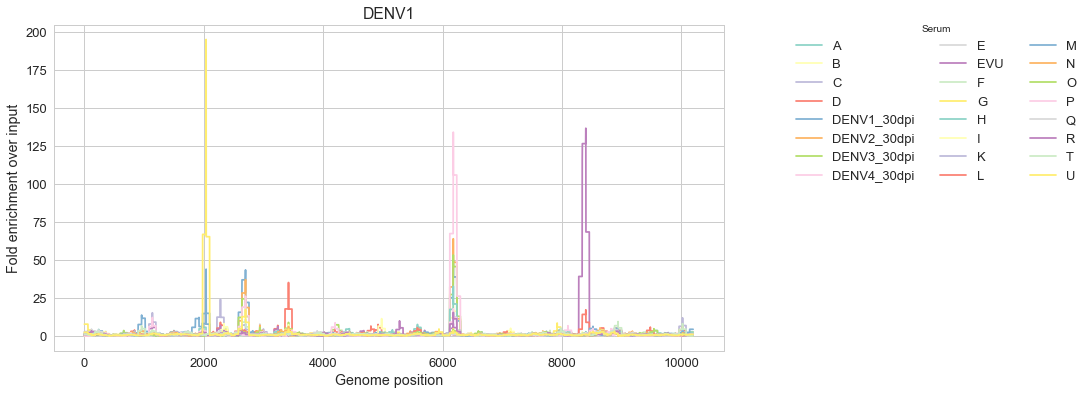

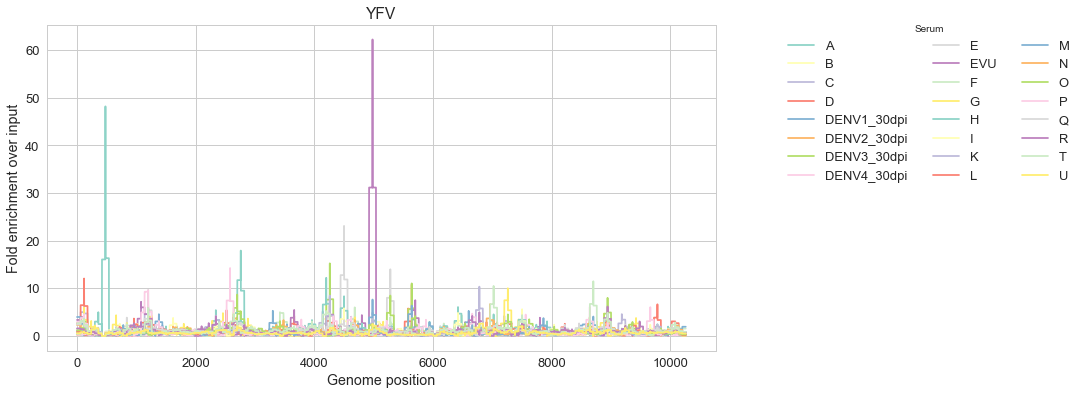

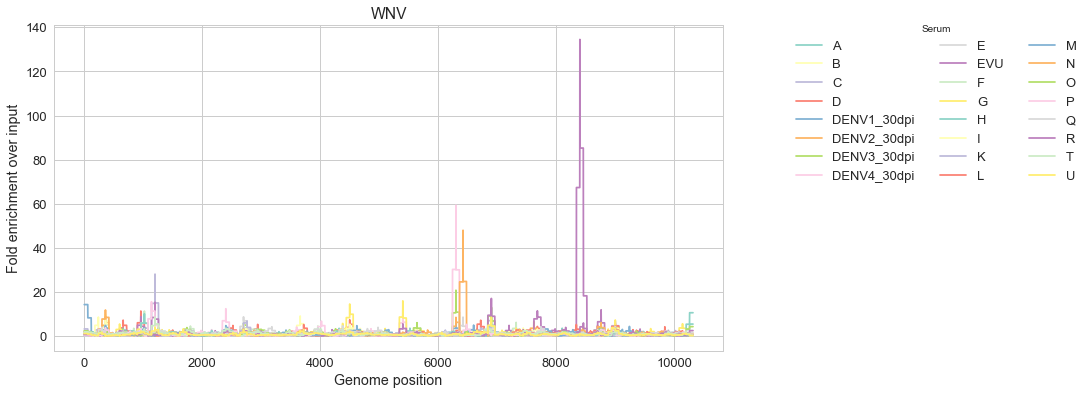

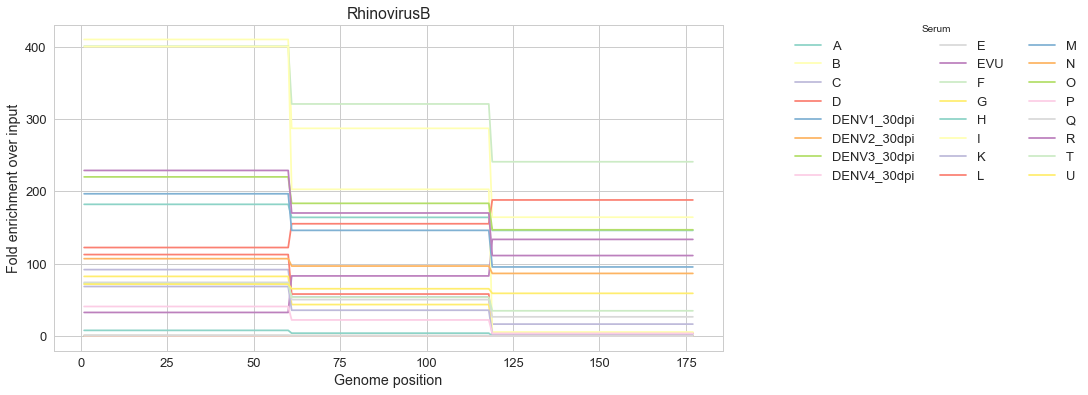

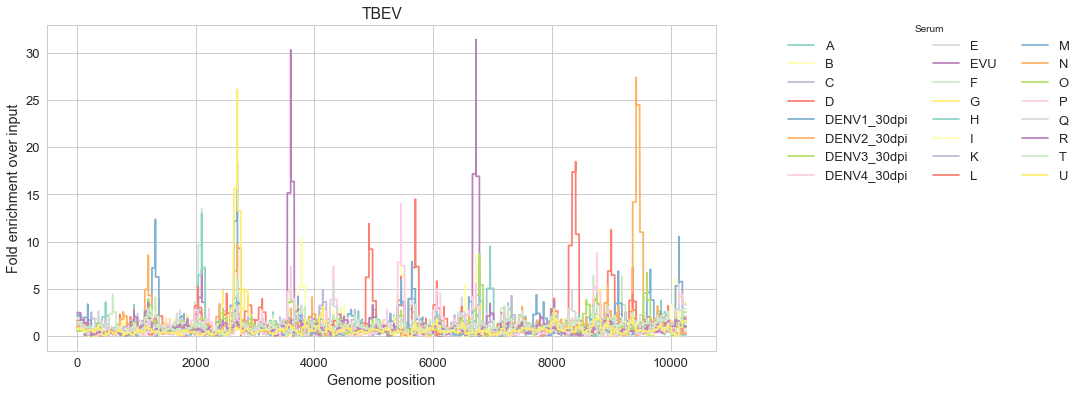

In [20]:
def plot_binding_footprint(virus, serum, ax=None):
    
    values = site_maps[virus][serum]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(values.index.values, values.values, label=serum)
    return ax

def plot_all_binding_footprints(virus):
    values = site_maps[virus]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for serum in sorted(sample_cols):
        plot_binding_footprint(virus, serum, ax)
    plt.legend(loc=[1.1,0.5], title='Serum', ncol=3)
    ax.set_title(virus)
    ax.set_xlabel('Genome position')
    ax.set_ylabel('Fold enrichment over input')
    plt.show()
        
for virus in site_maps.keys():
    plot_all_binding_footprints(virus)


In [24]:
def plot_interactive_binding_footprints(virus):
    values = site_maps[virus]
    traces = []
    
    for serum in sample_cols:
        vals = values[serum]
        
        trace = go.Scatter(
            x = vals.index.values,
            y = vals.values,
            mode = 'lines',
            name = serum)
        
        traces.append(trace)
    
    layout = dict(title = 'Oligos from %s'%virus,
              xaxis = dict(title = 'Genomic position'),
              yaxis = dict(title = 'Fold enrichment by sera'),
              )
    
    py.iplot(traces, filename='2018-03-28_'+virus)


for virus in site_maps.keys():
    plot_interactive_binding_footprints(virus)

The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.
The draw time for this plot will be slow for all clients.


In [ ]:
# def get_autologous_serum(serum, df):
#     ''' for a given serum sample, return a categorical series indicating whether 
#     each oligo in the dataframe is from an autologous virus and/or strain'''
#     autologous_strain = autologous_strains[serum].upper()
#     autologous_virus = serum
    
#     def is_autologous(row):
#         if row['virus'] == autologous_virus and autologous_strain in row['strains']:
#             return 'strain'
#         elif row['virus'] == autologous_virus: # strain not autologous but virus is
#             return 'virus'
#         else: # totally different virus
#             return 'no'
    
#     autologous = df.apply(is_autologous, axis=1) # map to every row in the dataframe
#     return autologous # return series (the index values here are the same in the original df, so they can be matched up later)

# def plot_sera_distrib(serum, df):
#     autologous = get_autologous_serum(serum, df) # categorize oligos by autologous-ness at virus and strain level
#     ax = sns.violinplot(df[serum], autologous) # plot distribution of enrichment scores from each category
#     ax.set_ylabel('Oligo from autologous\nvirus and strain?')
#     ax.set_xlabel('Enrichment score')
#     ax.set_title('Serum post innoculation with '+serum)
#     plt.show()
#     plt.close()
    
# for serum in sample_cols:
#     plot_sera_distrib(serum, data)